In [1]:
from google.colab import drive 
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
sns.set(font_scale=2)
sns.set(rc={'figure.figsize':(25,15)})
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import IsolationForest,RandomForestClassifier,StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score, accuracy_score,confusion_matrix, balanced_accuracy_score, roc_curve,auc
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import OneClassSVM
import xgboost as xgb
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,cross_val_score,RandomizedSearchCV
from sklearn.svm import LinearSVC, SVC
from imblearn.over_sampling import SMOTE
lsvc=LinearSVC(C=0.01, penalty="l1", dual=False)
feature_selector=SelectFromModel(lsvc,threshold='median')
from sklearn.externals import joblib
import warnings
warnings.filterwarnings('ignore')

In [0]:
df=pd.read_csv('gdrive/My Drive/predict_failure.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124494 entries, 0 to 124493
Data columns (total 12 columns):
date          124494 non-null object
device        124494 non-null object
failure       124494 non-null int64
attribute1    124494 non-null int64
attribute2    124494 non-null int64
attribute3    124494 non-null int64
attribute4    124494 non-null int64
attribute5    124494 non-null int64
attribute6    124494 non-null int64
attribute7    124494 non-null int64
attribute8    124494 non-null int64
attribute9    124494 non-null int64
dtypes: int64(10), object(2)
memory usage: 11.4+ MB


In [5]:
print(df.failure.value_counts())
print("the ratio of failure to non failure shows its an imbalanced data set: ",df.failure.value_counts()[1]/df.failure.value_counts()[0])

0    124388
1       106
Name: failure, dtype: int64
the ratio of failure to non failure shows its an imbalanced data set:  0.0008521722352638518


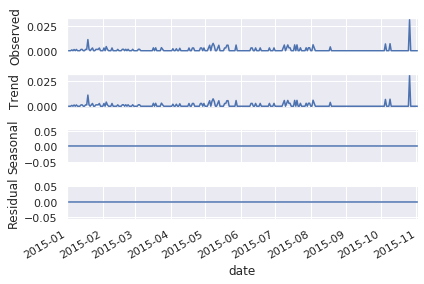

In [6]:
# checking if the date has an effect on failure rate or if the data has seasonality
df.date=pd.to_datetime(df.date)
failure_rate=df.groupby('date')['failure'].mean().reset_index()
failure_rate.index=failure_rate.date
result = seasonal_decompose(failure_rate.failure,freq=1, model='additive')
fig = result.plot()

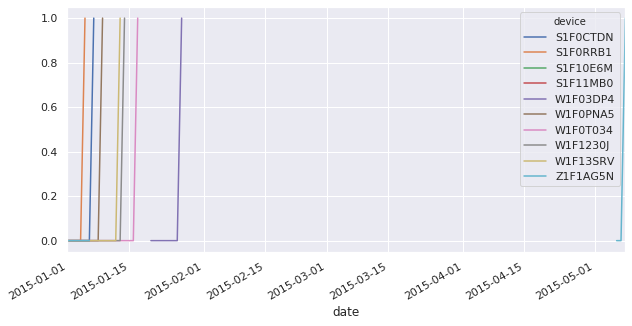

In [7]:
# Effect of device on time to failure 
devices = df.groupby(['device'])['failure'].mean().reset_index().sort_values(by='failure',ascending=False).head(10).device.tolist()
df[df.device.isin(devices)].groupby(['date','device'])['failure'].mean().unstack().reset_index().plot(x='date',figsize=(10,5))

**Time series**

* The overall failure rate does not show any observable trend with time. 
* Devices are replaced once they fail, hence it can't be used as a predictive feature.

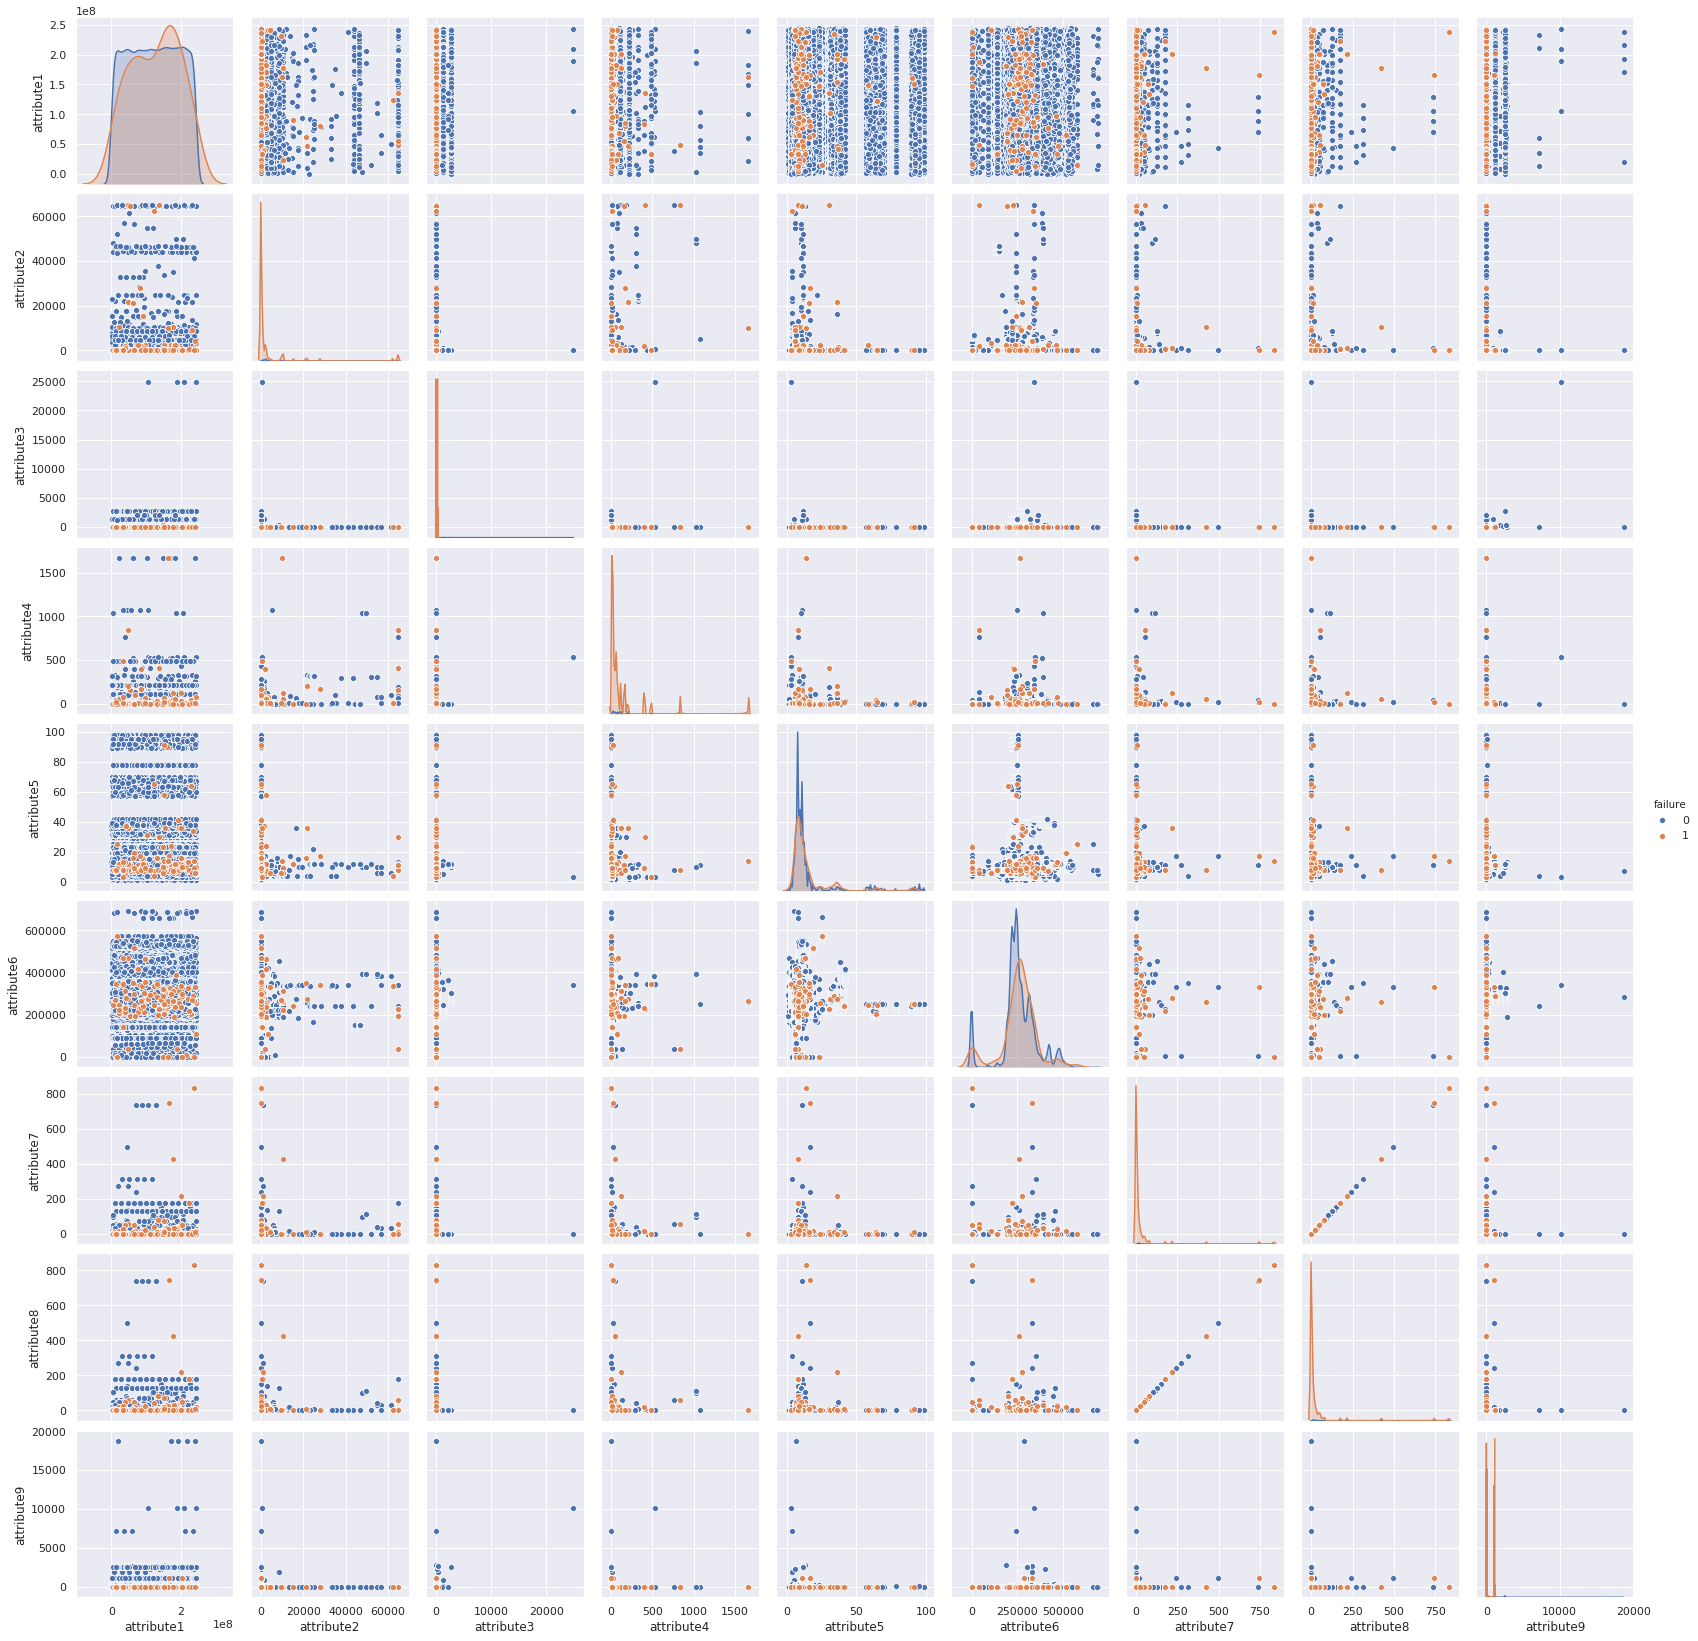

In [8]:
b=sns.pairplot(df[['attribute1', 'attribute2', 'attribute3','attribute4', 'attribute5','attribute6', 'attribute7', 'attribute8','attribute9','failure']]
               ,hue="failure")

## Model development


In [0]:
#helper functions 
class_mapping = {
    0: "Negative",
    1: "Positive"
}

def cls_spec_acc(y_test, pred_test):
    cmat = np.asarray(confusion_matrix(y_test, pred_test)).astype(float)
    per_class_acc = cmat.diagonal() / cmat.sum(axis=1)
    bal_acc = np.mean(per_class_acc)
    per_class_acc = np.append(per_class_acc, 
                              accuracy_score(y_test, pred_test))
    per_class_acc = np.append(per_class_acc, bal_acc)
    return per_class_acc

def print_accuracy(acc):
    print("-"*40)
    for ii in range(0, len(acc)-2):
        print("%12s: %.3f" %(class_mapping[ii], acc[ii]))
    print("%12s: %.3f" %("OVERALL", acc[-2]))
    print("%12s: %.3f" %("BALANCED", acc[-1]))
    print("")
    
def print_conf_matrix(test_y, y_pred_test):
    cmat = np.asarray(confusion_matrix(test_y, y_pred_test))
    index_mat = [class_mapping[k] for k in range(len(class_mapping.keys()))]
    df_conf = pd.DataFrame()
    for k in range(len(class_mapping.keys())):
        df_conf[index_mat[k]] = cmat[:,k]
    df_conf.index = index_mat
    print("confusion matrix \n\t True label")
    print(df_conf)
    print("")
    
def change_outlier_label(y):
    y[y == 1] = 0
    y[y == -1] = 1
    return y

def plot_roc(y_test, y_test_prob):
    probs = y_test_prob
    preds = y_test_prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [0]:
# Train-test stratified split of the data
features=['attribute1', 'attribute2', 'attribute3','attribute4','attribute5', 'attribute6', 'attribute7', 'attribute8','attribute9']
X_train,X_test,y_train,y_test = train_test_split(df[features],df.failure,test_size=.2,stratify=df.failure, random_state=20)

The class distribution is very imbalanced, so the first method I tried was anomaly detection using **isolation forest**. 

In [21]:
out_percent = 0.1
clf = IsolationForest(max_samples=2000, contamination=out_percent)
clf.fit(X_train)

y_pred_train = change_outlier_label(clf.predict(X_train))
y_pred_test = change_outlier_label(clf.predict(X_test))

print("Training accuracy")
print_accuracy(cls_spec_acc(y_train, y_pred_train))
print_conf_matrix(y_train, y_pred_train)
print("Test accuracy")
print_accuracy(cls_spec_acc(y_test, y_pred_test))
print_conf_matrix(y_test, y_pred_test)

Training accuracy
----------------------------------------
    Negative: 0.900
    Positive: 0.647
     OVERALL: 0.900
    BALANCED: 0.774

confusion matrix 
	 True label
          Negative  Positive
Negative     89605      9905
Positive        30        55

Test accuracy
----------------------------------------
    Negative: 0.898
    Positive: 0.571
     OVERALL: 0.898
    BALANCED: 0.735

confusion matrix 
	 True label
          Negative  Positive
Negative     22341      2537
Positive         9        12



Isolation Forest fails to detect the failures to a high accuracy level. 

## Supervised Classification with SMOTE

**Strategies**


* Models : Tested methods Logistic regression/SVM/Random Forest/XGBoost. 
* **Selected model: Xgboost**
* Imbalance Handling Strategies: Tested Weighting/SMOTE
* Feature Selection : Tested. XGboost can implictly handle feature selection not included in pipeline.
* Randomized grid search with 5 fold cross-validation for hyperparameter selection

In [0]:
# hyperparameters for grid search
grid_params = {"clf__n_estimators"     : list(range(5,30,2)) ,
               "clf__max_depth"        : list(range(3,15,3)),
               "clf__min_child_weight" : list(range(1,8,2)),
               "clf__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
               "clf__scale_pos_weight" : list(range(0,20,2)),
               "clf__reg_lambda"       : [ 0.0 ,0.3 ,0.6 , 0.9, 1.2 ,1.5 ,1.8 ]
               }

In [0]:
sm = SMOTE(sampling_strategy=0.8)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

In [17]:
pipeline = Pipeline([('scaler',StandardScaler())
                    ,('clf', xgb.XGBClassifier())])
pipeline = RandomizedSearchCV(pipeline, grid_params,scoring='balanced_accuracy',verbose=True,n_jobs=5)
pipeline.fit(X_train_res, y_train_res)

joblib.dump(pipeline.best_estimator_, 'best_estimator.pkl')
print(pipeline.best_estimator_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.6min
[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  1.7min finished


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.7, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=12,
                               min_child_weight=7, missing=None,
                               n_estimators=11, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=0.6, scale_pos_weight=6,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)


In [23]:
y_train_pred =  pipeline.predict(X_train_res)
y_test_pred = pipeline.predict(X_test)
y_test_prob = pipeline.predict_proba(X_test)
print("Training accuracy")
print_accuracy(cls_spec_acc(y_train_res, y_train_pred))
print_conf_matrix(y_train_res, y_train_pred)

print("Test accuracy")
print_accuracy(cls_spec_acc(y_test, y_test_pred))
print_conf_matrix(y_test, y_test_pred)

Training accuracy
----------------------------------------
    Negative: 0.965
    Positive: 1.000
     OVERALL: 0.980
    BALANCED: 0.982

confusion matrix 
	 True label
          Negative  Positive
Negative     96002      3508
Positive         8     79600

Test accuracy
----------------------------------------
    Negative: 0.962
    Positive: 0.857
     OVERALL: 0.962
    BALANCED: 0.910

confusion matrix 
	 True label
          Negative  Positive
Negative     23942       936
Positive         3        18



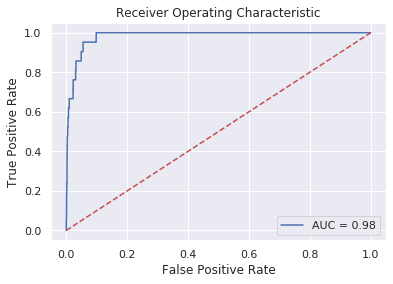

In [38]:
plot_roc(y_test, y_test_prob)

In [22]:
#class to train on existing data-set, test on the new data-set
# best estimator found using CV is saved in a pkl file. 
class failure_classification():
    def __init__(self,pipeline = None ):
        if pipeline:
            self.pipeline = pipeline
        else:
            self.pipeline = Pipeline([('scaler',StandardScaler()),('clf', xgb.XGBClassifier())])
        self.features = ['attribute1', 'attribute2', 'attribute3','attribute4','attribute5', 'attribute6', 'attribute7', 'attribute8','attribute9']

    def build_training_dataset(self,given_dataset_loc):  
        df=pd.read_csv(given_dataset_loc)
        self.X_train =df[self.features]
        self.y_train = df.failure

    def resample(self,sampling=.5):
        sm = SMOTE(sampling_strategy=sampling)
        self.X_train_res, self.y_train_res = sm.fit_resample(self.X_train, self.y_train)

    def fit(self):
        self.pipeline.fit(self.X_train_res,self.y_train_res)

    def training_accuracy(self):
        y_train_pred = self.pipeline.predict(self.X_train_res)
        print("Training accuracy: ")
        print_accuracy(cls_spec_acc(self.y_train_res, y_train_pred))
        print_conf_matrix(self.y_train_res, y_train_pred)

    def test_accuracy(self):
        y_test_pred = self.pipeline.predict(self.X_test)
        print("Test accuracy")
        print_accuracy(cls_spec_acc(self.y_test, y_test_pred))
        print_conf_matrix(self.y_test, y_test_pred)

    def predict(self,file_location):

        df_test= pd.read_csv(file_location)
        self.X_test = df_test[self.features]
        self.y_test = df_test.failure

        df_test['failure_prob'] = self.pipeline.predict_proba(self.X_test)[:,1].tolist()
        df_test.to_csv(file_location)


best_estimator = joblib.load('best_estimator.pkl')
model=failure_classification(best_estimator)
model.build_training_dataset('gdrive/My Drive/predict_failure.csv')
model.resample(.8)
model.fit()
model.predict('gdrive/My Drive/test.csv') #new file for prediction
model.training_accuracy()
model.test_accuracy()


Training accuracy: 
----------------------------------------
    Negative: 0.975
    Positive: 1.000
     OVERALL: 0.986
    BALANCED: 0.987

confusion matrix 
	 True label
          Negative  Positive
Negative    121303      3085
Positive        35     99475

Test accuracy
----------------------------------------
    Negative: 0.865
    Positive: 0.913
     OVERALL: 0.888
    BALANCED: 0.889

confusion matrix 
	 True label
          Negative  Positive
Negative        96        15
Positive         9        94



In [0]:
pip freeze --local > /content/gdrive/My\ Drive/requirements.txt